In [1]:
suppressPackageStartupMessages(suppressWarnings({
  library(arrow)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
}))

In [2]:
tukey_results_file_path <- file.path(
    "../data/0.ground_truth/tukey_results.parquet"
)
intensity_features_file_path <- file.path(
    "../data/0.ground_truth/annexinv_intensity_features_df.parquet"
)

figures_dir <- file.path("../figures/")
if (!dir.exists(figures_dir)) {
    dir.create(figures_dir)
}

# Read the intensity features
intensity_features_df <- arrow::read_parquet(intensity_features_file_path)

tukey_df <- arrow::read_parquet(tukey_results_file_path)
head(tukey_df)

group1,group2,meandiff,p-adj,lower,upper,reject,feature,p-adj_bh,__index_level_0__
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<int>
0,0.61,0.4855,0.9945,-1.1743,2.1452,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1.0000000,0
0,1.22,0.6877,0.9421,-0.9720,2.3475,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1.0000000,1
0,2.44,0.5774,0.9838,-1.1196,2.2744,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1.0000000,2
0,4.88,0.1214,1.0000,-1.5384,1.7811,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1.0000000,3
0,9.77,1.3755,0.1961,-0.2842,3.0352,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,0.9013671,4
0,19.53,-0.0405,1.0000,-1.7002,1.6193,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1.0000000,5


In [3]:
# get the intensity feature only
tukey_df <- tukey_df %>% filter(feature == "Intensity_MedianIntensity_AnnexinV")

In [4]:
# tidy long
intensity_features_df <- intensity_features_df %>%
    pivot_longer(
        cols = colnames(intensity_features_df)[-1],
        names_to = "feature",
        values_to = "value"
    )

# select only annexin features 
intensity_features_df$channel <- gsub("Intensity_", "", intensity_features_df$feature)
intensity_features_df$channel <- sub(".*_(.*)", "\\1", intensity_features_df$feature)
intensity_features_df <- intensity_features_df %>% filter(
    channel == "AnnexinV"
)
head(intensity_features_df)

Metadata_dose,feature,value,channel
<dbl>,<chr>,<dbl>,<chr>
1.22,Intensity_LowerQuartileIntensity_AnnexinV,-0.5259237,AnnexinV
1.22,Intensity_MADIntensity_AnnexinV,-1.4458366,AnnexinV
1.22,Intensity_MaxIntensity_AnnexinV,-0.4281593,AnnexinV
1.22,Intensity_MeanIntensity_AnnexinV,-1.6096171,AnnexinV
1.22,Intensity_UpperQuartileIntensity_AnnexinV,-1.5075567,AnnexinV
1.22,Intensity_LowerQuartileIntensity_AnnexinV,-0.5259237,AnnexinV


In [5]:
intensity_features_df$Metadata_dose <- as.character(intensity_features_df$Metadata_dose)
intensity_features_df$Metadata_dose <- factor(
    intensity_features_df$Metadata_dose,
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
)
    )

### Plot the intensity features for each feature and dose

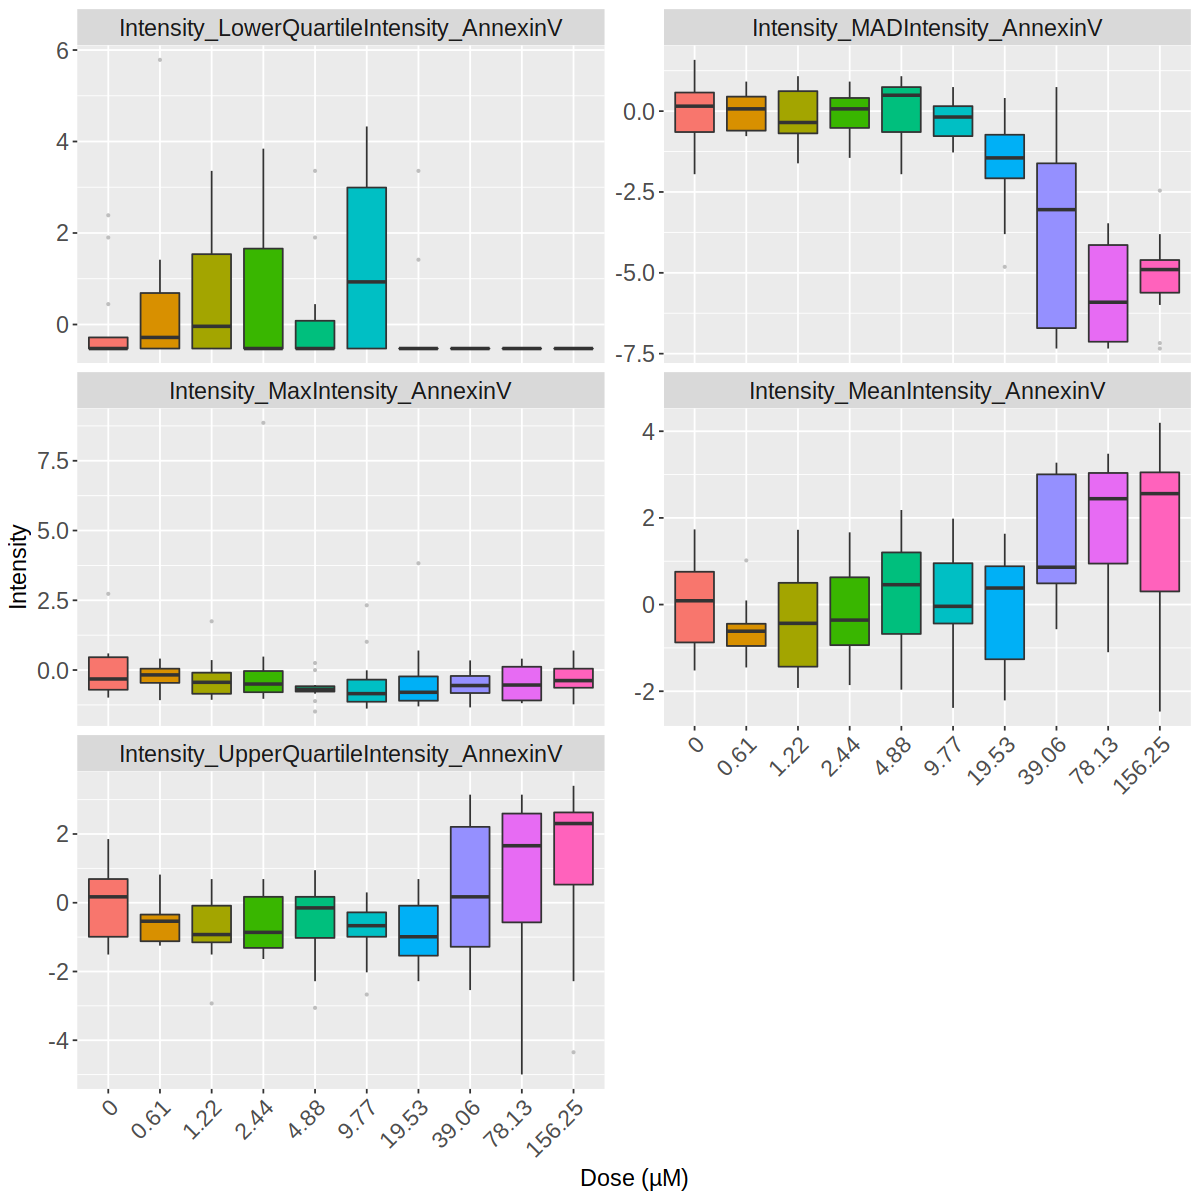

In [6]:
# plot the intensity_features_df
width <- 10
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
intensity_plot <- (
    ggplot(intensity_features_df, aes(x = Metadata_dose, y = value, fill = Metadata_dose))
    + geom_boxplot(aes(group=Metadata_dose), outlier.size = 0.5, outlier.colour = "gray")
    + labs(
        x = "Dose (µM)",
        y = "Intensity",
    )
    + facet_wrap(~ feature, scales = "free_y", ncol = 2)
        + theme(
        axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        axis.text.y = element_text(size = 14),
        plot.title = element_text(size = 14, hjust = 0.5),
        legend.position = "none",
        strip.text = element_text(size = 14)
    )
)
ggsave(
    file.path(figures_dir, "intensity_features_boxplot.png"),
    plot = intensity_plot,
    width = width,
    height = height,
    dpi = 600
)
intensity_plot

In [7]:
# sort the data by group1 and group2
tukey_df <- tukey_df %>%
    arrange(group1, group2)
# make sure the group1 and group2 are factors
tukey_df$comparison <- paste0(
  tukey_df$group1, "_", tukey_df$group2
)
tukey_df$channel <- sub(".*_(.*)", "\\1", tukey_df$feature)

### Add the tukey post hoc test plot

In [8]:
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
tukey_plot <- (
    ggplot(tukey_df, aes(x = meandiff, y = comparison, col = channel)) 
    + geom_point(size = 3) 
    + geom_errorbar(aes(xmin = lower, xmax = upper), width = 0.2) 
    + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 
    + labs(
        x = "Group Comparison",
        y = "Mean Difference"
    ) 
    + theme_bw() 
    + theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
    + facet_wrap(feature ~ ., scales = "free_y") 
    
        + facet_wrap(~ feature, scales = "free_y", ncol = 2)
        + theme(
        axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        axis.text.y = element_text(size = 14),
        plot.title = element_text(size = 14, hjust = 0.5),
        legend.position = "none",
        strip.text = element_text(size = 14)
    )
)
ggsave(
    file.path(figures_dir, "tukey_plot.png"),
    plot = tukey_plot,
    width = width,
    height = height,
    dpi = 600
)
tukey_plot


ERROR: [1m[33mError[39m in `combine_vars()`:[22m
[33m![39m Faceting variables must have at least one value
